In [1]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv("seminars/train_sem2.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#clean data
for i in data.columns:
    num = np.sum(data[i].notnull())
    if num < 500:
        print(i, num)
        data = data.drop(columns=i)


Alley 91
PoolQC 7
Fence 281
MiscFeature 54


In [4]:
from sklearn.model_selection import StratifiedKFold as SK
from sklearn.model_selection import train_test_split
y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns


X_train = X_train.fillna(numeric_data_mean)
X_train_num = X_train.select_dtypes([np.number])

X_test = X_test.fillna(numeric_data_mean)
X_test_num = X_test.select_dtypes([np.number])

In [263]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def linear(model, X, y, **kwards):
    skf = SK(n_splits=5, random_state=42, shuffle=True)
    model = model(**kwards)
    mean = []
    models = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        models.append(model)
        mean.append(mean_squared_error(y_test, y_pred, squared=False))
    return np.mean(mean), models

mean, models = linear(Lasso, X_train_num.values, y_train.values, random_state=42)
mean

42058.28657215064

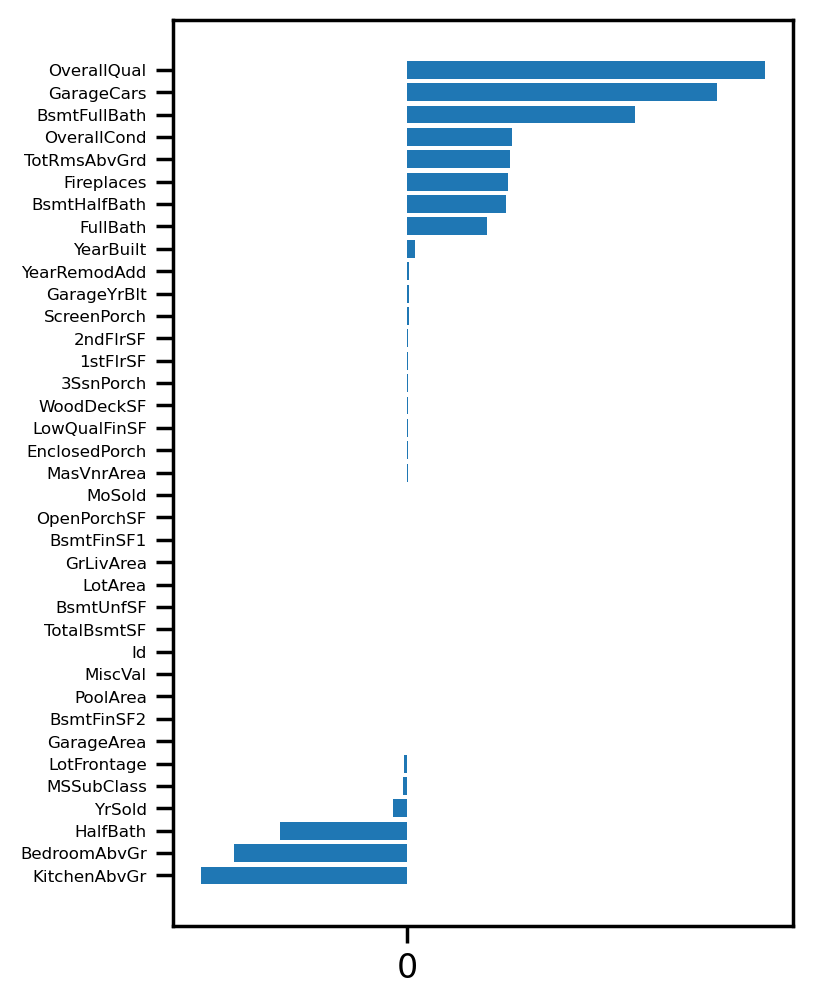

In [264]:
def drawWeight(X, model):
    fig, ax = plt.subplots(dpi=200, figsize=(4, 6))
    wnames = sorted(zip(X.columns, model.coef_), key=lambda x: x[1])
    weights = [i[1] for i in wnames]
    names = [i[0] for i in wnames]
    ax.barh(names, weights)
    ax.set_yticks(range(len(names)), names, fontsize=6)
    ax.set_xticks([0], ['0'], fontsize=12)
drawWeight(X_train_num, models[2])

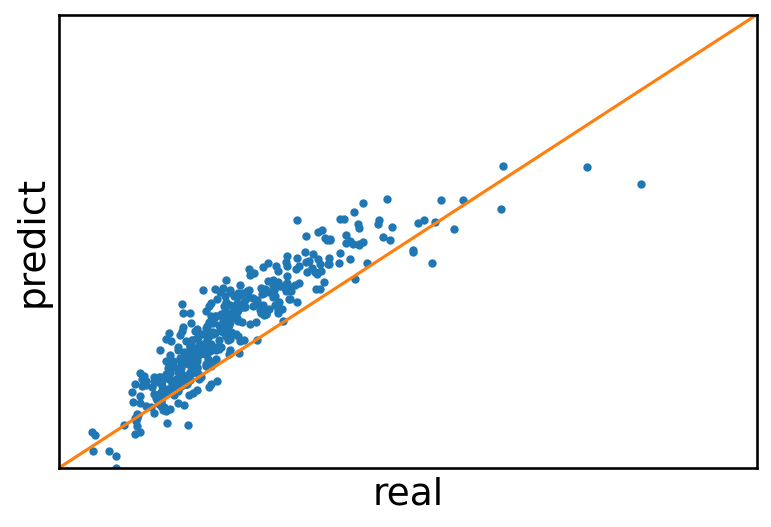

In [276]:
from sklearn.linear_model import Ridge
mean, models = linear(Ridge, X_train_num.values, y_train.values, random_state=42)

def draw_realPred(y_pred, y_test=y_test):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(y_test, y_pred, '.')
    max_val = np.max(y_test)
    ax.plot([0, max_val*2], [0, np.max(max_val)*2], '-')
    ax.set(xlim=(0, max_val*1.2), ylim=(0, max_val*1.2), xticks=([]), yticks=([]), xlabel='real', ylabel='predict')

def mean_models_draw(models, X_test_num=X_test_num, y_test=y_test):
    for cnt, i in enumerate(models):
        if cnt == 0:
            y_pred = i.predict(X_test_num)
        else:
            y_pred += i.predict(X_test_num)
    y_pred /=4
    draw_realPred(y_pred, y_test)
    
mean_models_draw(models)

In [277]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# make it automat
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-2, 4, 30)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_num_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 221.2216


41728.08490316065

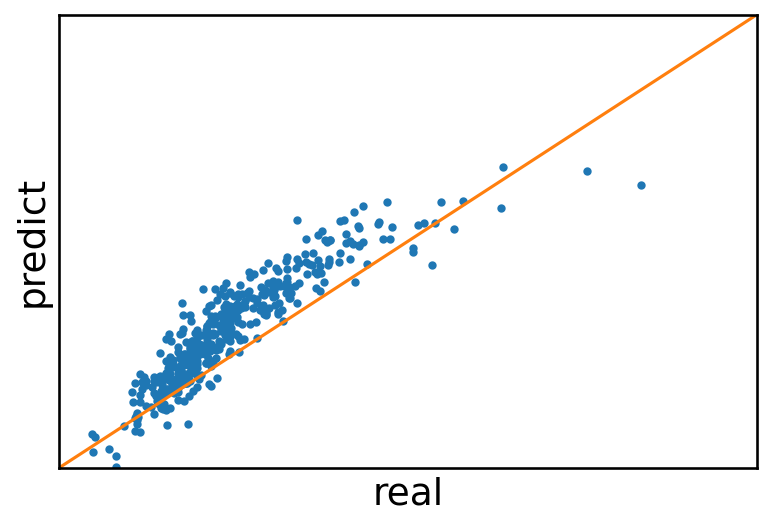

In [278]:
mean, models = linear(Lasso, X_train_num_scaled, y_train.values, random_state=42, alpha=best_alpha)
mean_models_draw(models, X_test_num_scaled)
mean

Test RMSE = 31918.2872


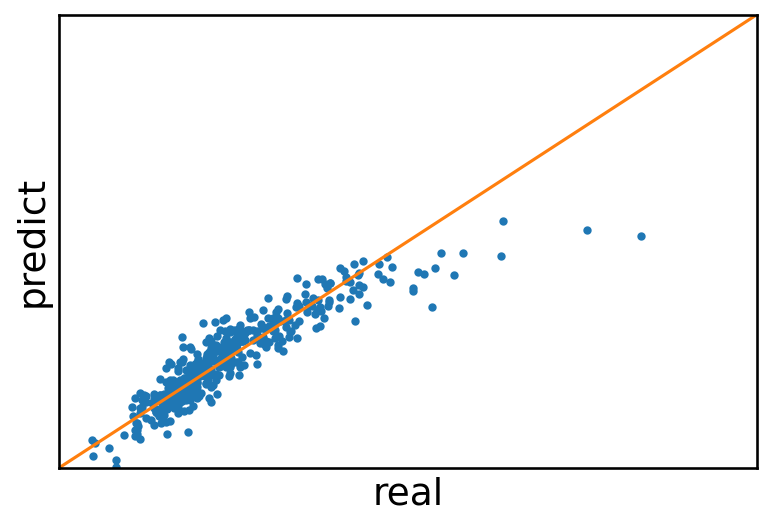

In [292]:
# skale and other automaticly
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Lasso(alpha=best_alpha))
])

model = simple_pipeline.fit(X_train_num, y_train)
y_pred = model.predict(X_test_num)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
draw_realPred(y_pred)

Test RMSE = 25134.5020


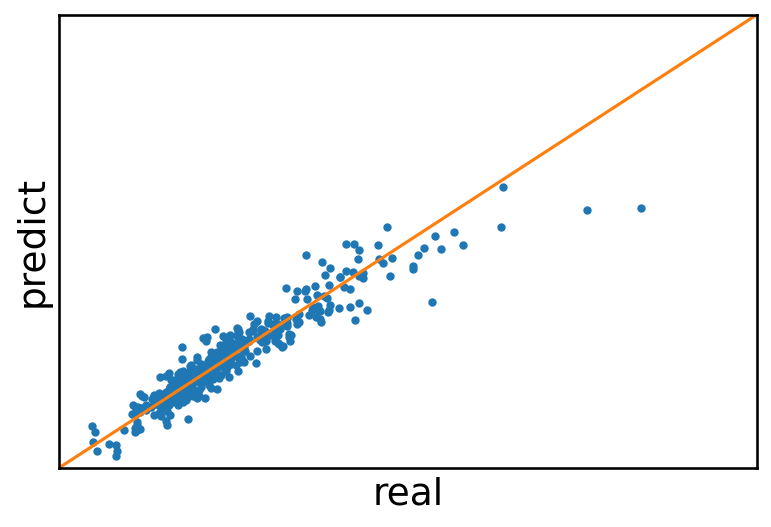

In [293]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# sort 
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
categorical.append('YrSold')
numeric_features_notYear = list(numeric_features)
numeric_features_notYear.remove('YrSold')
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features_notYear)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
draw_realPred(y_pred)

In [281]:
# searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
#                         scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
# searcher.fit(X_train, y_train)

# best_alpha = searcher.best_params_["regression__alpha"]
# print("Best alpha = %.4f" % best_alpha)

# plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
# plt.xlabel("alpha")
# plt.ylabel("CV score")

In [282]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 203


In [283]:
error = (y_train - model.predict(X_train)) ** 2
mask = (error < np.quantile(error, 0.95))
model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 24471.1388


Test RMSE = 23787.67


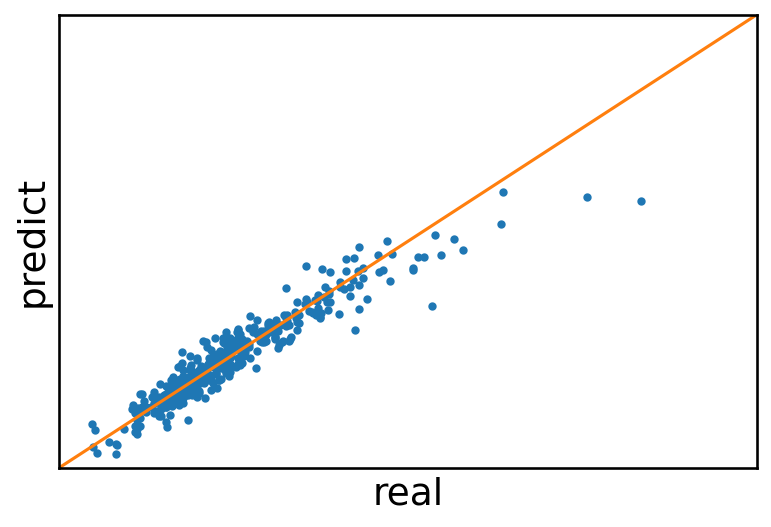

In [285]:
from scipy.stats.mstats import winsorize # замена слишком больших и малых значений на значение крайнего квантиля

X_train_win = X_train.copy()
X_train_win[numeric_features_notYear] = winsorize(X_train_win[numeric_features_notYear].values, limits=(0.0, 0.05)).data

model = pipeline.fit(X_train_win, y_train)
y_pred = model.predict(X_test)

draw_realPred(y_pred)

print("Test RMSE = %.2f" % mean_squared_error(y_test, y_pred, squared=False))